## Performs regressiono on net photosynthetic rate data, in order to use it as continuous data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az

In [3]:
net_photosynthetic_rate = pd.read_csv("../data/soybean_net_photosynthetic_rate.csv", 
                                      index_col="Photosynthetically Active Radiation [micromol / m^2 / s]")

In [4]:
net_photosynthetic_rate

,Monocropping - CO2 uptake [micromol / m^2 / s],Intercropping - CO2 uptake [micromol / m^2 / s]
Photosynthetically Active Radiation [micromol / m^2 / s],,
0.0,-3.5,-2.5
25.0,-2.7,-0.7
50.0,-0.9,0.8
75.0,1.0,2.3
100.0,2.0,3.0
200.0,6.0,7.0
400.0,12.5,11.0
600.0,17.0,12.5
800.0,20.0,14.5


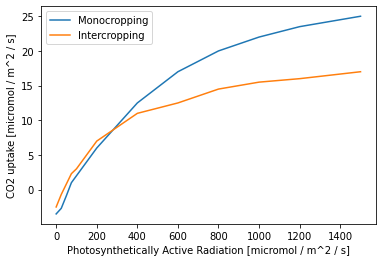

In [5]:
fig, ax = plt.subplots()
net_photosynthetic_rate.plot(ylabel='CO2 uptake [micromol / m^2 / s]', ax=ax)
ax.legend(['Monocropping', 'Intercropping'])

In [10]:
net_photosynthetic_rate.rename(columns ={'Monocropping - CO2 uptake [micromol / m^2 / s]': 'Monocropping', 
                                         'Intercropping - CO2 uptake [micromol / m^2 / s]': 'Intercropping'},
                               inplace=True)

In [11]:
net_photosynthetic_rate

,Monocropping,Intercropping
Photosynthetically Active Radiation [micromol / m^2 / s],,
0.0,-3.5,-2.5
25.0,-2.7,-0.7
50.0,-0.9,0.8
75.0,1.0,2.3
100.0,2.0,3.0
200.0,6.0,7.0
400.0,12.5,11.0
600.0,17.0,12.5
800.0,20.0,14.5


In [12]:
net_photosynthetic_rate.index.names = ['PAR']

In [13]:
net_photosynthetic_rate

,Monocropping,Intercropping
PAR,,
0.0,-3.5,-2.5
25.0,-2.7,-0.7
50.0,-0.9,0.8
75.0,1.0,2.3
100.0,2.0,3.0
200.0,6.0,7.0
400.0,12.5,11.0
600.0,17.0,12.5
800.0,20.0,14.5


In [16]:
net_photosynthetic_rate.index.values

array([   0.,   25.,   50.,   75.,  100.,  200.,  400.,  600.,  800.,
       1000., 1200., 1500.])

### Use sqrt for regression (extension of linear regression)

In [17]:
with pm.Model() as model_sqrt:
    β = pm.Normal("β", sigma=10, shape=2)
    μ = pm.Deterministic("μ", β[0] + β[1] * np.sqrt(
        net_photosynthetic_rate.index.values))
    σ = pm.HalfNormal("σ", sigma=10)
    co2_updake = pm.Normal("co2_updake", mu=μ, sigma=σ, 
                           observed=net_photosynthetic_rate["Monocropping"])
    inf_data_sqrt = pm.sample(draws=2000, tune=4000)
    ppc_data_sqrt = pm.sample_posterior_predictive(inf_data_sqrt)
    inf_data_sqrt = az.from_pymc3(trace=inf_data_sqrt,
                                  posterior_predictive=ppc_data_sqrt)

/Users/tadatoshi/Documents/development/projects/tadatoshi_solar_research_society/agrivoltaics_supply_side_management/venv/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β]


Sampling 2 chains for 4_000 tune and 2_000 draw iterations (8_000 + 4_000 draws total) took 57 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [18]:
μ_m = inf_data_sqrt.posterior["μ"].values.reshape(-1, net_photosynthetic_rate["Monocropping"].shape[0]).mean(axis=0)

/var/folders/8n/f15shvd92vv8t4gykc82yrdm0000gn/T/ipykernel_7692/2472243848.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "C0." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(net_photosynthetic_rate.index, net_photosynthetic_rate["Monocropping"], 'C0.',


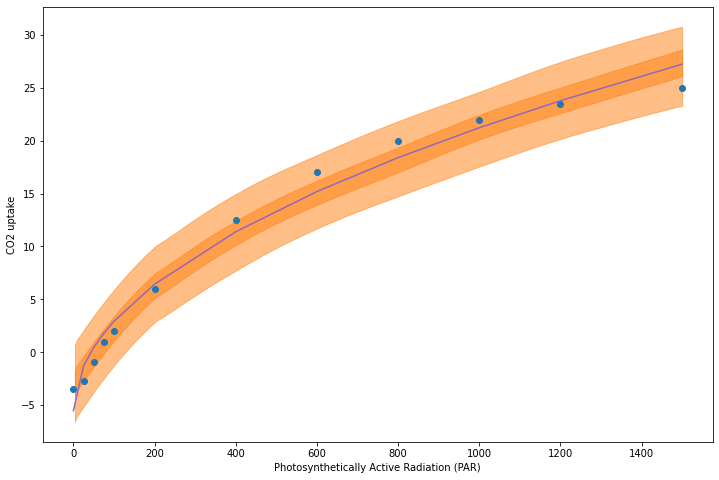

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(net_photosynthetic_rate.index, net_photosynthetic_rate["Monocropping"], 'C0.', 
        marker='o')

ax.set_ylabel("CO2 uptake")
ax.set_xlabel("Photosynthetically Active Radiation (PAR)");

az.plot_hdi(net_photosynthetic_rate.index, 
            inf_data_sqrt.posterior_predictive["co2_updake"], hdi_prob=.50, ax=ax)
az.plot_hdi(net_photosynthetic_rate.index, 
            inf_data_sqrt.posterior_predictive["co2_updake"], hdi_prob=.94, ax=ax)

ax.plot(net_photosynthetic_rate.index, μ_m, c='C4')

plt.savefig('../plots/net_photosynthetic_rate/monocropping_co2_uptake_sqrt_fit.png', dpi=300)